In [279]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings('ignore')

In [280]:
df = pd.read_csv('heart_cleaned.csv')

In [281]:
class FeatureCategorizer:
    def __init__(self, df):
        self.df = df.copy()
        self.continuous_features = []
        self.binary_features = []
        
    def categorize_features(self):
        """Automatically categorize features as continuous or binary"""
        print("Analyzing features...")
        print("="*50)
        
        for col in self.df.columns:
            unique_vals = self.df[col].nunique()
            is_numeric = pd.api.types.is_numeric_dtype(self.df[col])
            unique_values = sorted(self.df[col].unique())
            
            print(f"\n{col}:")
            print(f"  - Unique values: {unique_vals}")
            print(f"  - Is numeric: {is_numeric}")
            print(f"  - Sample values: {unique_values[:5] if len(unique_values) > 5 else unique_values}")
            
            if is_numeric:
                if unique_vals == 2 or set(self.df[col].unique()).issubset({0, 1, 0.0, 1.0}):
                    self.binary_features.append(col)
                    print(f"  → Classified as: BINARY")
                else:
                    self.continuous_features.append(col)
                    print(f"  → Classified as: CONTINUOUS")
            else:
                # Handle boolean or string binary features
                if unique_vals == 2:
                    self.binary_features.append(col)
                    print(f"  → Classified as: BINARY")
                else:
                    print(f"  → Classified as: OTHER (will be ignored)")
        
        print(f"\n{'='*50}")
        print("FINAL CATEGORIZATION:")
        print(f"{'='*50}")
        print(f"Continuous features ({len(self.continuous_features)}): {self.continuous_features}")
        print(f"Binary features ({len(self.binary_features)}): {self.binary_features}")
        
        return self.continuous_features, self.binary_features
    
    def get_feature_stats(self):
        """Get detailed statistics for each feature type"""
        print(f"\n{'='*50}")
        print("FEATURE STATISTICS:")
        print(f"{'='*50}")
        
        if self.continuous_features:
            print("\nCONTINUOUS FEATURES:")
            for feature in self.continuous_features:
                data = self.df[feature]
                print(f"\n{feature}:")
                print(f"  Mean: {data.mean():.2f}")
                print(f"  Std:  {data.std():.2f}")
                print(f"  Min:  {data.min():.2f}")
                print(f"  Max:  {data.max():.2f}")
                print(f"  Q1:   {data.quantile(0.25):.2f}")
                print(f"  Q3:   {data.quantile(0.75):.2f}")
        
        if self.binary_features:
            print("\nBINARY FEATURES:")
            for feature in self.binary_features:
                value_counts = self.df[feature].value_counts()
                print(f"\n{feature}:")
                for val, count in value_counts.items():
                    percentage = (count / len(self.df)) * 100
                    print(f"  {val}: {count} ({percentage:.1f}%)")

In [282]:
# Categorize features
categorizer = FeatureCategorizer(df)
continuous_features, binary_features = categorizer.categorize_features()

# Get detailed statistics
categorizer.get_feature_stats()

Analyzing features...

Age:
  - Unique values: 50
  - Is numeric: True
  - Sample values: [np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32)]
  → Classified as: CONTINUOUS

Sex:
  - Unique values: 2
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(1)]
  → Classified as: BINARY

RestingBP:
  - Unique values: 67
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(80), np.int64(92), np.int64(94), np.int64(95)]
  → Classified as: CONTINUOUS

Cholesterol:
  - Unique values: 222
  - Is numeric: True
  - Sample values: [np.float64(85.0), np.float64(100.0), np.float64(110.0), np.float64(113.0), np.float64(117.0)]
  → Classified as: CONTINUOUS

FastingBS:
  - Unique values: 2
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(1)]
  → Classified as: BINARY

MaxHR:
  - Unique values: 119
  - Is numeric: True
  - Sample values: [np.int64(60), np.int64(63), np.int64(67), np.int64(69), np.int64(70)]
  → Classified as: CONTINUOUS

ExerciseAngina

In [283]:
class ProgressiveOutlierGenerator:
    def __init__(self, df, continuous_features, pre_fitted_scaler=None, pre_fitted_pca=None):
        self.original_df = df.copy()
        self.current_df = df.copy()
        self.continuous_features = continuous_features
        self.contamination_history = []
        self.outlier_indices = set()
        
        # Note: PCA models are no longer needed for univariate-only generation
        # but we keep the parameters for backwards compatibility
        self.scaler = pre_fitted_scaler
        self.pca = pre_fitted_pca

        print(f"Initialized with:")
        print(f"  - Dataset size: {len(df)} samples")
        print(f"  - Continuous features: {len(continuous_features)}")
        print(f"  - Mode: Univariate outliers only")

    def add_continuous_outliers(self, contamination_rate=0.02, methods=['extreme']):
        """Add univariate outliers to continuous features."""
        if not self.continuous_features:
            print("No continuous features to contaminate.")
            return {}

        # Filter out multivariate methods
        univariate_methods = [m for m in methods if m != 'multivariate']
        if not univariate_methods:
            print("No valid univariate methods provided. Using 'extreme' as default.")
            univariate_methods = ['extreme']

        n_samples = len(self.current_df)
        n_new_outliers = int(n_samples * contamination_rate)
        
        available_indices = list(set(range(n_samples)) - self.outlier_indices)
        
        if len(available_indices) < n_new_outliers:
            n_new_outliers = len(available_indices)
            if n_new_outliers > 0:
                print(f"Warning: Only {len(available_indices)} clean samples remaining. Using all of them.")
        
        if n_new_outliers == 0:
            print("No more clean samples available for contamination.")
            return {}
        
        outlier_indices = np.random.choice(available_indices, n_new_outliers, replace=False)
        
        contamination_info = {}
        
        # Assign univariate methods and features to each outlier
        contamination_assignments = []
        outlier_indices_list = list(outlier_indices)
        np.random.shuffle(outlier_indices_list)
        
        for idx in outlier_indices_list:
            contamination_assignments.append({
                'index': idx,
                'method': np.random.choice(univariate_methods),
                'feature': np.random.choice(self.continuous_features)
            })

        # Apply contamination
        for assignment in contamination_assignments:
            idx = assignment['index']
            method = assignment['method']
            feature = assignment['feature']
            
            original_val = self.current_df.loc[idx].copy()
            
            # Calculate statistics for clean data only
            clean_data = self.current_df[feature].loc[list(set(self.current_df.index) - self.outlier_indices)]
            q1, q3 = clean_data.quantile(0.25), clean_data.quantile(0.75)
            iqr = q3 - q1
            std_val = clean_data.std()
            min_val, max_val = clean_data.min(), clean_data.max()
            
            if method == 'extreme':
                # Create extreme values beyond IQR bounds
                if np.random.random() < 0.5:
                    outlier_val = q1 - np.random.uniform(3, 6) * iqr
                    outlier_val = max(outlier_val, min_val - 3 * std_val)
                else:
                    outlier_val = q3 + np.random.uniform(3, 6) * iqr
                    outlier_val = min(outlier_val, max_val + 3 * std_val)
            
            elif method == 'shift':
                # Shift the original value by multiple standard deviations
                shift_factor = np.random.choice([-1, 1]) * np.random.uniform(2, 4)
                outlier_val = original_val[feature] + shift_factor * std_val
            
            elif method == 'noise':
                # Add large random noise
                noise_factor = np.random.choice([-1, 1]) * np.random.uniform(3, 5)
                outlier_val = original_val[feature] + noise_factor * std_val
            
            else:
                print(f"Warning: Unknown method '{method}'. Using 'extreme' instead.")
                if np.random.random() < 0.5:
                    outlier_val = q1 - np.random.uniform(3, 6) * iqr
                else:
                    outlier_val = q3 + np.random.uniform(3, 6) * iqr
            
            # Ensure non-negative values for certain features
            if feature in ['Age', 'RestingBP', 'Cholesterol', 'MaxHR'] and outlier_val < 0:
                outlier_val = abs(outlier_val)
            
            # Apply the outlier value
            self.current_df.loc[idx, feature] = outlier_val
            
            # Record contamination info
            contamination_info.setdefault(feature, []).append({
                'index': idx,
                'original_value': original_val[feature],
                'outlier_value': outlier_val,
                'method': method
            })

        self.outlier_indices.update(outlier_indices)
        
        return contamination_info

    def progressive_contamination(self, steps=10, max_contamination=1, continuous_methods=['extreme', 'shift']):
        """Progressively contaminate the dataset in steps with univariate outliers only."""
        # Filter out multivariate methods
        univariate_methods = [m for m in continuous_methods if m != 'multivariate']
        if not univariate_methods:
            print("No valid univariate methods provided. Using default methods.")
            univariate_methods = ['extreme', 'shift']
        
        contamination_rates = np.linspace(0, max_contamination, steps + 1)[1:]
        datasets = [self.original_df.copy()]
        
        print("Starting progressive contamination (univariate only)...")
        print(f"Steps: {steps}")
        print(f"Methods: {univariate_methods}")
        print(f"Contamination rates: {[f'{rate:.3f}' for rate in contamination_rates]}")
        
        for step, target_rate in enumerate(contamination_rates, 1):
            print(f"\n--- Step {step}/{steps}: Target contamination {target_rate:.3f} ---")
            
            current_contamination_rate = len(self.outlier_indices) / len(self.current_df)
            incremental_rate = target_rate - current_contamination_rate
            
            if incremental_rate <= 0:
                print("Target contamination already reached or exceeded.")
                datasets.append(self.current_df.copy())
                continue
            
            print(f"Adding univariate outliers (rate: {incremental_rate:.3f})...")
            cont_info = self.add_continuous_outliers(
                contamination_rate=incremental_rate,
                methods=univariate_methods
            )
            
            actual_contamination = len(self.outlier_indices) / len(self.current_df)
            print(f"Actual total contamination: {actual_contamination:.3f}")
            print(f"Total contaminated samples: {len(self.outlier_indices)}")
            
            self.contamination_history.append({
                'step': step,
                'target_rate': target_rate,
                'actual_rate': actual_contamination,
                'contaminated_samples': len(self.outlier_indices),
                'continuous_info': cont_info,
            })
            
            datasets.append(self.current_df.copy())
        
        return datasets, self.contamination_history

    def get_contamination_summary(self):
        """Print a detailed summary of contamination."""
        print(f"\n{'='*60}")
        print("CONTAMINATION SUMMARY (UNIVARIATE ONLY)")
        print(f"{'='*60}")
        
        print(f"Original dataset size: {len(self.original_df)} samples")
        print(f"Total contaminated samples: {len(self.outlier_indices)}")
        
        for i, history in enumerate(self.contamination_history, 1):
            print(f"\nStep {i}:")
            print(f"  Target rate: {history['target_rate']:.3f}")
            print(f"  Actual rate: {history['actual_rate']:.3f}")
            print(f"  Contaminated samples: {history['contaminated_samples']}")
            
            if history['continuous_info']:
                print("  Univariate outliers by feature:")
                for feature, outliers in history['continuous_info'].items():
                    if outliers:
                        method_counts = {}
                        for outlier in outliers:
                            method = outlier['method']
                            method_counts[method] = method_counts.get(method, 0) + 1
                        
                        method_str = ", ".join([f"{method}: {count}" for method, count in method_counts.items()])
                        print(f"    {feature}: {len(outliers)} new outliers ({method_str})")

    def visualize_contamination_progress(self, figsize=(15, 8)):
        """Visualize the contamination progress for continuous features."""
        if not self.continuous_features:
            print("No continuous features to visualize.")
            return
        
        n_features = min(len(self.continuous_features), 6)
        features_to_plot = self.continuous_features[:n_features]
        
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        axes = axes.flatten()
        
        for i, feature in enumerate(features_to_plot):
            ax = axes[i]
            
            original_data = self.original_df[feature]
            contaminated_data = self.current_df[feature]
            
            ax.hist(original_data, alpha=0.6, label='Original', bins=30, color='blue')
            ax.hist(contaminated_data, alpha=0.6, label='Contaminated', bins=30, color='red')
            
            # Collect outlier values for this feature
            outlier_values = []
            for history in self.contamination_history:
                if feature in history['continuous_info']:
                    for outlier in history['continuous_info'][feature]:
                        outlier_values.append(outlier['outlier_value'])
            
            if outlier_values:
                ax.scatter(outlier_values, [0.1] * len(outlier_values), 
                          color='red', s=30, alpha=0.8, marker='x', 
                          label=f'Univariate Outliers ({len(outlier_values)})')
            
            ax.set_title(f'{feature}')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for j in range(n_features, 6):
            fig.delaxes(axes[j])
        
        plt.suptitle('Original vs Contaminated Data Distribution (Univariate Outliers)', fontsize=16)
        plt.tight_layout()
        plt.show()

    def plot_contamination_progress(self):
        """Plot contamination progress over steps."""
        if not self.contamination_history:
            print("No contamination history to plot.")
            return
        
        steps = [h['step'] for h in self.contamination_history]
        actual_rates = [h['actual_rate'] for h in self.contamination_history]
        target_rates = [h['target_rate'] for h in self.contamination_history]
        contaminated_counts = [h['contaminated_samples'] for h in self.contamination_history]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot([0] + steps, [0] + actual_rates, 'o-', label='Actual Rate', color='red')
        ax1.plot([0] + steps, [0] + target_rates, 'o--', label='Target Rate', color='blue')
        ax1.set_xlabel('Contamination Step')
        ax1.set_ylabel('Contamination Rate')
        ax1.set_title('Contamination Rate Progress (Univariate)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.plot([0] + steps, [0] + contaminated_counts, 'o-', color='orange')
        ax2.set_xlabel('Contamination Step')
        ax2.set_ylabel('Number of Contaminated Samples')
        ax2.set_title('Cumulative Contaminated Samples')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def reset_to_clean(self):
        """Reset to original clean dataset."""
        self.current_df = self.original_df.copy()
        self.outlier_indices = set()
        self.contamination_history = []
        print("Dataset reset to original clean state.")
    
    def get_datasets(self):
        """Return both clean and current contaminated dataset."""
        return self.original_df.copy(), self.current_df.copy()
    
    def debug_outlier_counts(self):
        """Debug function to check outlier counts per feature and method"""
        print("\n" + "="*60)
        print("OUTLIER DEBUG INFORMATION (UNIVARIATE ONLY)")
        print("="*60)
        
        for feature in self.continuous_features:
            method_counts = {}
            
            for history in self.contamination_history:
                if feature in history['continuous_info']:
                    for outlier_info in history['continuous_info'][feature]:
                        method = outlier_info['method']
                        method_counts[method] = method_counts.get(method, 0) + 1
            
            print(f"{feature}:")
            if method_counts:
                for method, count in method_counts.items():
                    print(f"  - {method} outliers: {count}")
                print(f"  - Total outliers: {sum(method_counts.values())}")
            else:
                print(f"  - No outliers")
            print()

In [284]:
loaded_scaler = joblib.load('scaler.joblib')
loaded_pca = joblib.load('pca.joblib')

# Initialize the outlier generator with categorized features
generator = ProgressiveOutlierGenerator(df, continuous_features, pre_fitted_scaler=loaded_scaler, 
    pre_fitted_pca=loaded_pca)

# Generate progressive outliers
datasets, contamination_history = generator.progressive_contamination(
    steps=10,                          
    max_contamination=1,           
    continuous_methods=['extreme', 'shift', 'noise']  
)

# Print detailed summary
generator.get_contamination_summary()

Initialized with:
  - Dataset size: 918 samples
  - Continuous features: 5
  - Mode: Univariate outliers only
Starting progressive contamination (univariate only)...
Steps: 10
Methods: ['extreme', 'shift', 'noise']
Contamination rates: ['0.100', '0.200', '0.300', '0.400', '0.500', '0.600', '0.700', '0.800', '0.900', '1.000']

--- Step 1/10: Target contamination 0.100 ---
Adding univariate outliers (rate: 0.100)...
Actual total contamination: 0.099
Total contaminated samples: 91

--- Step 2/10: Target contamination 0.200 ---
Adding univariate outliers (rate: 0.101)...
Actual total contamination: 0.199
Total contaminated samples: 183

--- Step 3/10: Target contamination 0.300 ---
Adding univariate outliers (rate: 0.101)...
Actual total contamination: 0.300
Total contaminated samples: 275

--- Step 4/10: Target contamination 0.400 ---
Adding univariate outliers (rate: 0.100)...
Actual total contamination: 0.400
Total contaminated samples: 367

--- Step 5/10: Target contamination 0.500 ---

Generating visualizations with only univariate outliers...


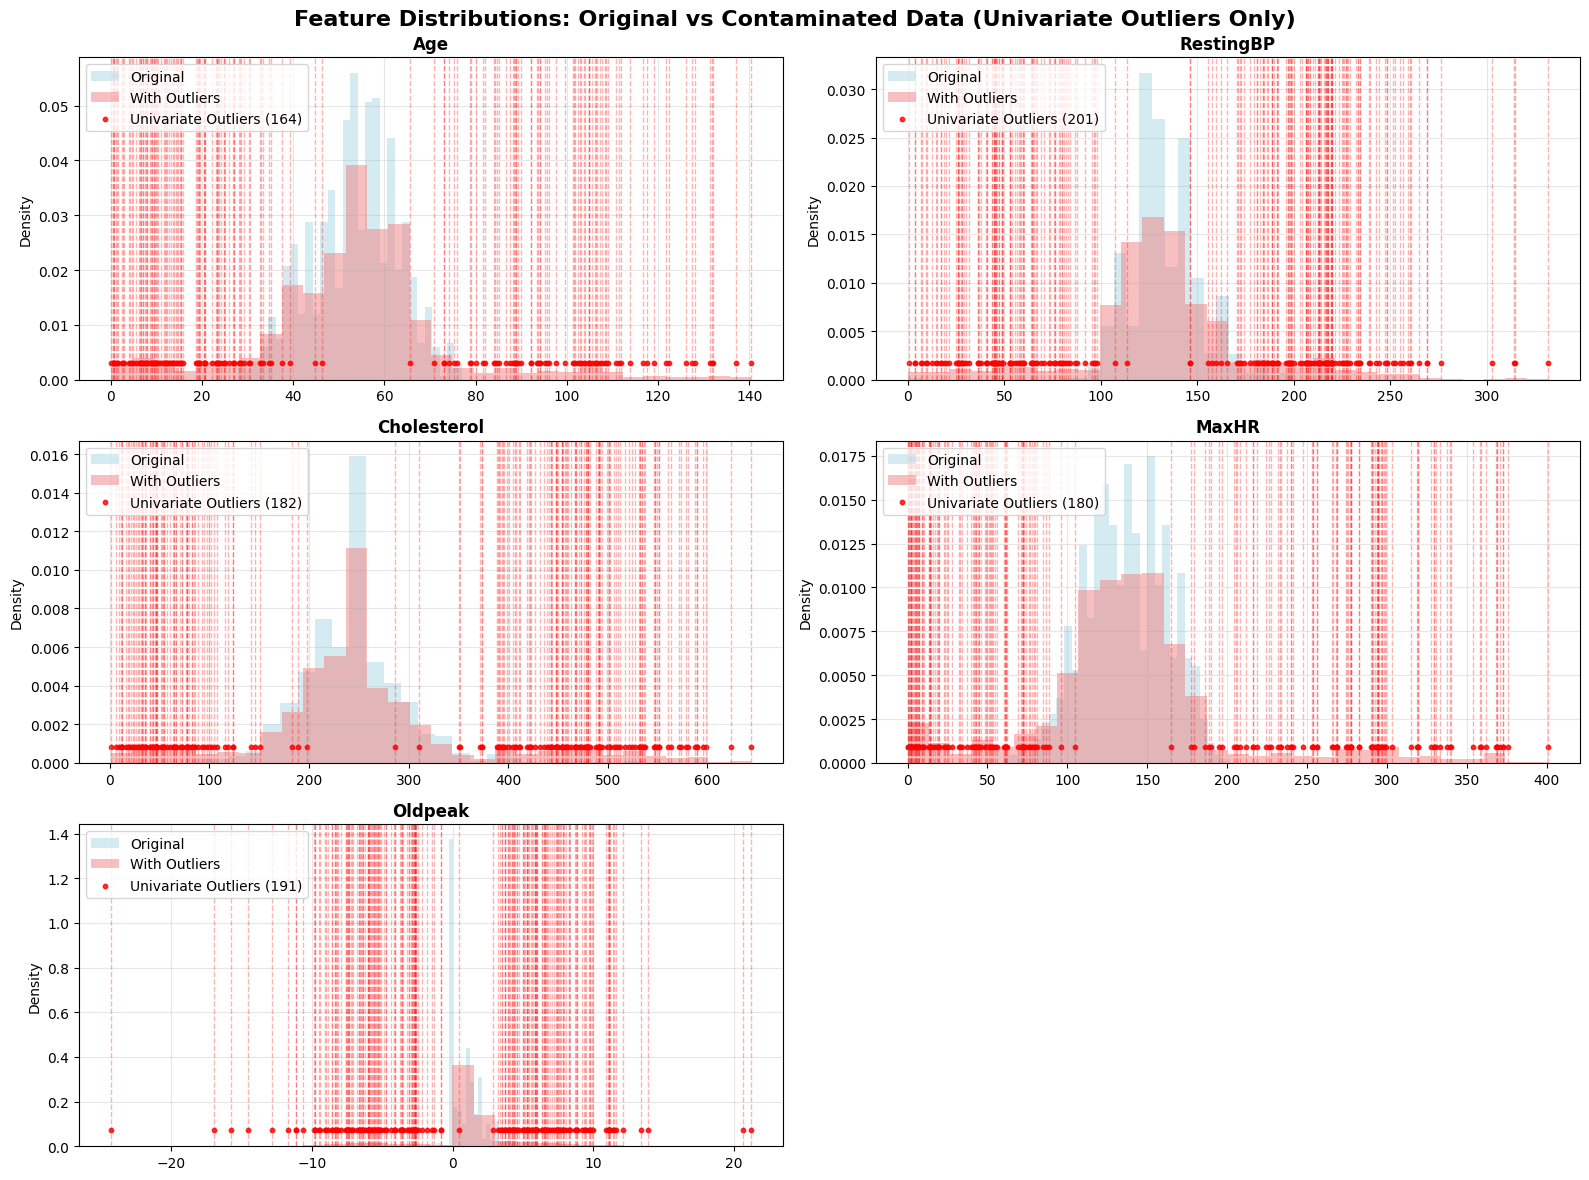

In [285]:
def plot_feature_distributions_with_univariate_outliers(generator, figsize=(16, 12)):
    """
    Plot distributions showing original data vs contaminated data with only univariate outliers highlighted.
    """
    n_features = len(generator.continuous_features)
    
    if n_features == 0:
        print("No features to visualize")
        return
    
    # Calculate grid size
    n_cols = 2
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle single row case
    if n_rows == 1:
        if n_cols == 1:
            axes = [axes]
        else:
            axes = axes.reshape(1, -1)
    
    # Flatten axes array for easier indexing
    axes_flat = axes.flatten() if n_features > 1 else [axes]
    
    for i, feature in enumerate(generator.continuous_features):
        ax = axes_flat[i]
        
        # Get original and contaminated data
        original_data = generator.original_df[feature]
        contaminated_data = generator.current_df[feature]
        
        # Plot histograms
        ax.hist(original_data, alpha=0.5, label='Original', bins=30, 
                color='lightblue', density=True)
        ax.hist(contaminated_data, alpha=0.5, label='With Outliers', bins=30, 
                color='lightcoral', density=True)
        
        # --- ONLY UNIVARIATE OUTLIERS ---
        univariate_outliers = []
        for history in generator.contamination_history:
            if feature in history['continuous_info']:
                for outlier_info in history['continuous_info'][feature]:
                    if outlier_info['method'] != 'multivariate':
                        univariate_outliers.append(outlier_info['outlier_value'])
        
        # Plot univariate outliers
        if univariate_outliers:
            y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05
            ax.scatter(univariate_outliers, [y_pos] * len(univariate_outliers), 
                       color='red', s=10, alpha=0.8, marker='o', 
                       label=f'Univariate Outliers ({len(univariate_outliers)})')
            for val in univariate_outliers:
                ax.axvline(x=val, color='red', linestyle='--', alpha=0.3, linewidth=1)
        
        ax.set_ylabel('Density')
        ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left')
        ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for j in range(n_features, len(axes_flat)):
        fig.delaxes(axes_flat[j])
    
    plt.suptitle('Feature Distributions: Original vs Contaminated Data (Univariate Outliers Only)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Usage
print("Generating visualizations with only univariate outliers...")
plot_feature_distributions_with_univariate_outliers(generator)

In [286]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import time

In [287]:
all_metrics_outliers = []

def calculate_metrics(y_test, y_pred, model_name, approach, step_idx):
    """
    Calculate metrics and return a dictionary with model info
    """
    metrics = {
        'model': model_name,
        'approach': approach,
        'step': step_idx,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    
    # Print metrics (to maintain your current output format)
    print(f"Misure di performance globali {model_name.lower()} {approach.lower()}\n")
    print('Accuracy:', metrics['accuracy'])
    print('Precision:', metrics['precision'])
    print('Recall:', metrics['recall'])
    print('F1-score:', metrics['f1_score'])
    
    return metrics

timing_collector_outliers = {
    'dt_naive_training': 0,
    'dt_optimal_training': 0, 
    'dt_hyperparameter': 0,
    'svm_naive_training': 0,
    'svm_optimal_training': 0,
    'svm_hyperparameter': 0,
    'nn_naive_training': 0,
    'nn_optimal_training': 0,
    'nn_hyperparameter': 0
}

Creating clean test set from original data...
Clean test set size: 184 samples
Test set will remain constant across all contamination steps


===== Training Decision Tree at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time: 0.0025 sec
Step 0 | Training Accuracy: 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7554347826086957
Precision: 0.8444444444444444
Recall: 0.7102803738317757
F1-score: 0.7715736040609137


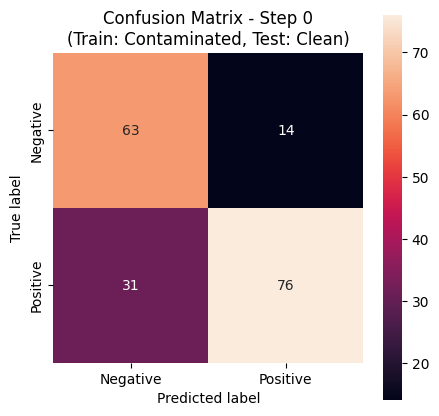


===== Training Decision Tree at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time: 0.0026 sec
Step 1 | Training Accuracy: 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7771739130434783
Precision: 0.851063829787234
Recall: 0.7476635514018691
F1-score: 0.7960199004975125


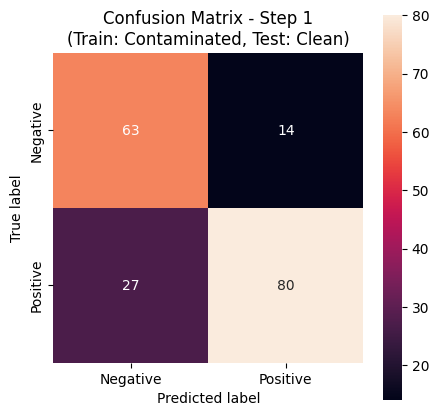


===== Training Decision Tree at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time: 0.0027 sec
Step 2 | Training Accuracy: 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8152173913043478
Precision: 0.8686868686868687
Recall: 0.8037383177570093
F1-score: 0.8349514563106796


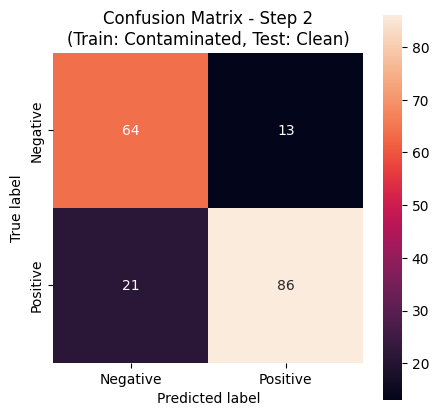


===== Training Decision Tree at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time: 0.0025 sec
Step 3 | Training Accuracy: 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7717391304347826
Precision: 0.8350515463917526
Recall: 0.7570093457943925
F1-score: 0.7941176470588235


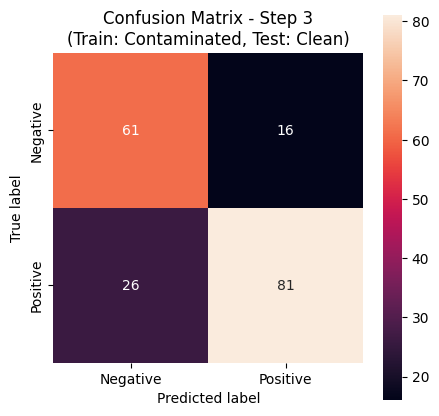


===== Training Decision Tree at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time: 0.0028 sec
Step 4 | Training Accuracy: 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7989130434782609
Precision: 0.8645833333333334
Recall: 0.7757009345794392
F1-score: 0.8177339901477833


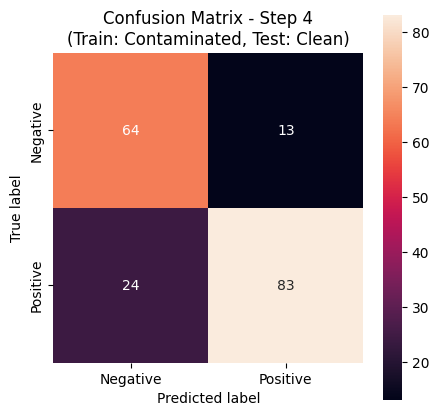


===== Training Decision Tree at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time: 0.0028 sec
Step 5 | Training Accuracy: 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7880434782608695
Precision: 0.8469387755102041
Recall: 0.7757009345794392
F1-score: 0.8097560975609757


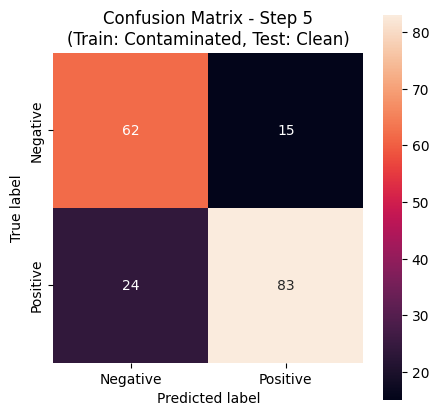


===== Training Decision Tree at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time: 0.0028 sec
Step 6 | Training Accuracy: 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7663043478260869
Precision: 0.8333333333333334
Recall: 0.7476635514018691
F1-score: 0.7881773399014779


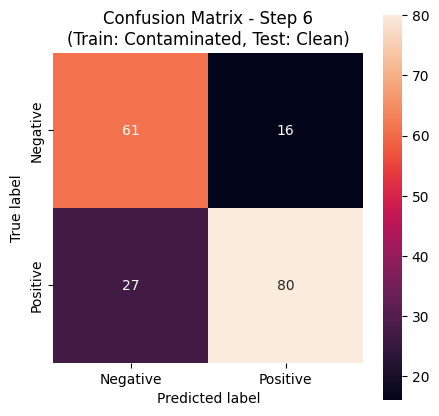


===== Training Decision Tree at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time: 0.0028 sec
Step 7 | Training Accuracy: 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7880434782608695
Precision: 0.8469387755102041
Recall: 0.7757009345794392
F1-score: 0.8097560975609757


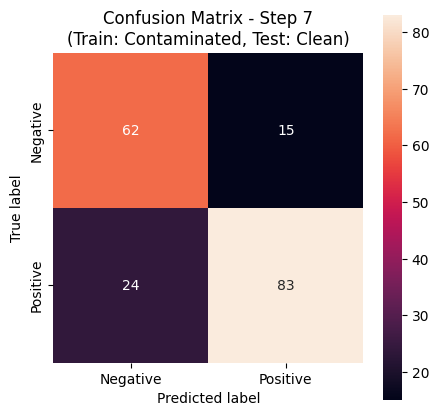


===== Training Decision Tree at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time: 0.0029 sec
Step 8 | Training Accuracy: 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7880434782608695
Precision: 0.8541666666666666
Recall: 0.7663551401869159
F1-score: 0.8078817733990148


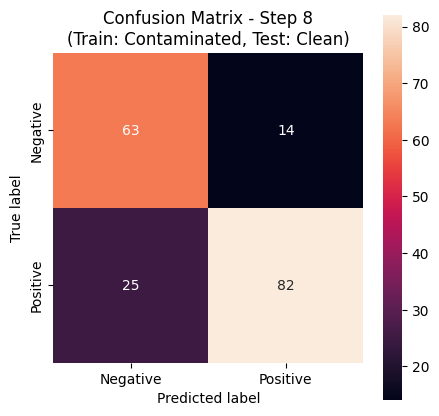


===== Training Decision Tree at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time: 0.0030 sec
Step 9 | Training Accuracy: 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7934782608695652
Precision: 0.8349514563106796
Recall: 0.8037383177570093
F1-score: 0.819047619047619


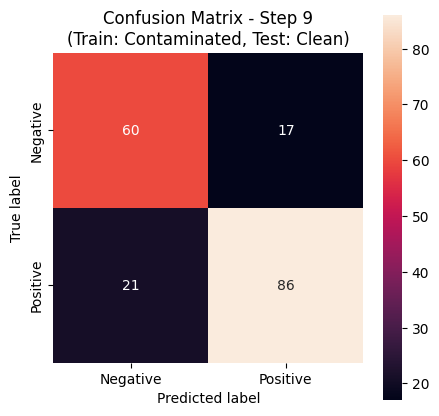


===== Training Decision Tree at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time: 0.0033 sec
Step 10 | Training Accuracy: 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8206521739130435
Precision: 0.8363636363636363
Recall: 0.8598130841121495
F1-score: 0.847926267281106


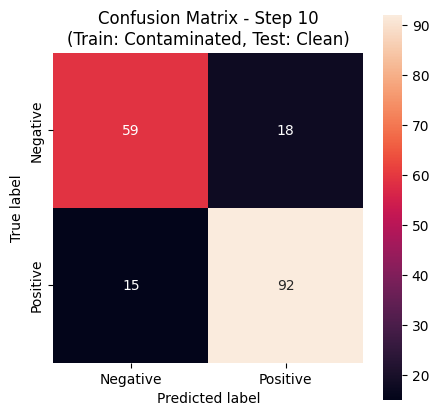

In [288]:
# Prima del loop, creiamo una volta sola il test set pulito
print("Creating clean test set from original data...")
X_original = df.drop('HeartDisease', axis=1)  # df è il dataset originale pulito
y_original = df['HeartDisease']

# Split del dataset originale per ottenere il test set pulito
X_temp, X_test_clean, y_temp, y_test_clean = train_test_split(
    X_original, y_original, test_size=0.2, random_state=0
)

print(f"Clean test set size: {len(X_test_clean)} samples")
print("Test set will remain constant across all contamination steps\n")

for step_idx, contaminated_df in enumerate(datasets):
    print(f"\n===== Training Decision Tree at Step {step_idx} =====")
    
    # Prepara X e y dal dataset contaminato per il TRAINING
    X_contaminated = contaminated_df.drop('HeartDisease', axis=1)
    y_contaminated = contaminated_df['HeartDisease']
    
    # Split del dataset contaminato SOLO per ottenere il training set
    # Usiamo lo stesso random_state per garantire coerenza negli indici
    X_train_contaminated, X_temp_contaminated, y_train_contaminated, y_temp_contaminated = train_test_split(
        X_contaminated, y_contaminated, test_size=0.2, random_state=0
    )
    
    # Il training set usa i dati contaminati, il test set rimane pulito
    X_train = X_train_contaminated
    y_train = y_train_contaminated
    X_test = X_test_clean      # SEMPRE pulito
    y_test = y_test_clean      # SEMPRE pulito
    
    print(f"Training set size: {len(X_train)} samples (contaminated)")
    print(f"Test set size: {len(X_test)} samples (clean)")
    
    if step_idx > 0:  # Solo per i passi con contaminazione
        contaminated_training_samples = len(set(X_train.index) & generator.outlier_indices)
        print(f"Contaminated samples in training set: {contaminated_training_samples}")
    
    # Crea e addestra Decision Tree
    clf = DecisionTreeClassifier(random_state=300)
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Step {step_idx} | Training time: {training_time:.4f} sec")
    
    # Salva il tempo nel dizionario
    timing_collector_outliers[f'dt_naive_training_step_{step_idx}'] = training_time
    
    # Accuracy sul training (contaminato)
    accuracy_train = clf.score(X_train, y_train)
    print(f"Step {step_idx} | Training Accuracy: {accuracy_train:.4f}")
    
    # Predizioni sul test set PULITO
    y_pred = clf.predict(X_test)
    
    # Report e metriche (test su dati puliti)
    dt_metrics = calculate_metrics(y_test, y_pred, 'Decision Tree', 'Naive', step_idx)
    dt_metrics['training_time'] = training_time
    dt_metrics['train_accuracy'] = accuracy_train
    dt_metrics['contamination_step'] = step_idx
    dt_metrics['test_set_type'] = 'clean'  # Indica che il test è sempre pulito
    
    # Aggiungi alle metriche globali
    all_metrics_outliers.append(dt_metrics)
    
    # Confusion matrix (basata su test pulito)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f"Confusion Matrix - Step {step_idx}\n(Train: Contaminated, Test: Clean)")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

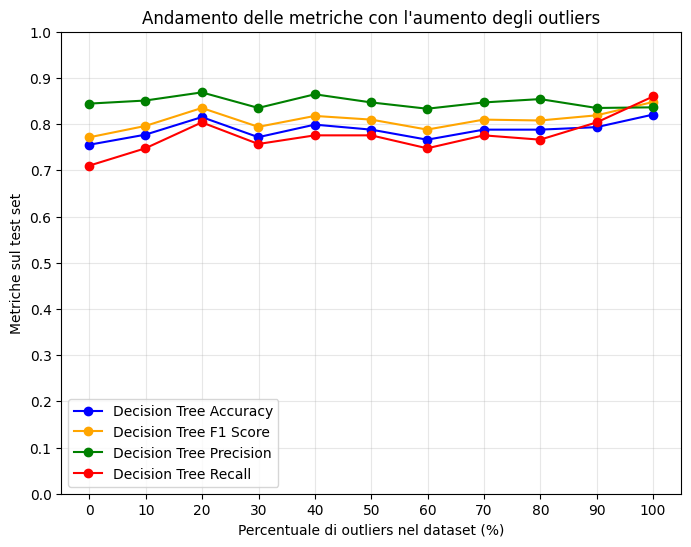

In [289]:
# Creo DataFrame da contamination_history con step e contamination rate
contam_df = pd.DataFrame([
    {"step": h['step'], "contamination_rate": h['actual_rate']}
    for h in contamination_history
])

# Aggiungo il caso iniziale (0% outliers)
if 0 not in contam_df["step"].values:
    contam_df = pd.concat([
        pd.DataFrame([{"step": 0, "contamination_rate": 0.0}]),
        contam_df
    ], ignore_index=True)

# Creo DataFrame dalle metriche
metrics_df = pd.DataFrame(all_metrics_outliers)

# Merge su 'step'
merged_df = pd.merge(metrics_df, contam_df, on="step", how="left")

# Ordino i valori
merged_df = merged_df.sort_values("contamination_rate")

# === FILTRO PER APPROACH ===
naive_df = merged_df[(merged_df["approach"] == "Naive") & (merged_df["model"] == "Decision Tree")]

# Plot accuracy vs contamination rate
plt.figure(figsize=(8,6))
plt.plot(naive_df["contamination_rate"]*100, naive_df["accuracy"], marker='o', color='blue', label="Decision Tree Accuracy")
plt.plot(naive_df["contamination_rate"]*100, naive_df["f1_score"], marker='o', color='orange', label="Decision Tree F1 Score")
plt.plot(naive_df["contamination_rate"]*100, naive_df["precision"], marker='o', color='green', label="Decision Tree Precision")
plt.plot(naive_df["contamination_rate"]*100, naive_df["recall"], marker='o', color='red', label="Decision Tree Recall")
plt.xlabel("Percentuale di outliers nel dataset (%)")
plt.ylabel("Metriche sul test set")
plt.title("Andamento delle metriche con l'aumento degli outliers")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 110, 10))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()




OPTIMIZED DECISION TREE


===== Training Optimized Decision Tree at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (OPT): 0.0011 sec
Step 0 | Training Accuracy (OPT): 0.8706
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


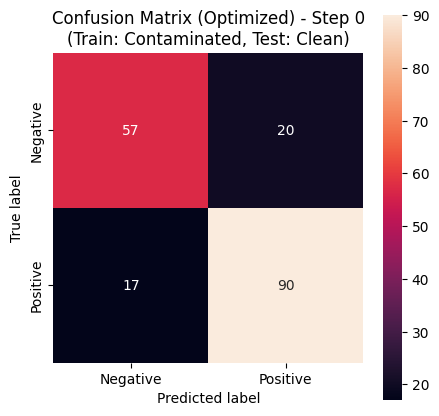


===== Training Optimized Decision Tree at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (OPT): 0.0015 sec
Step 1 | Training Accuracy (OPT): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


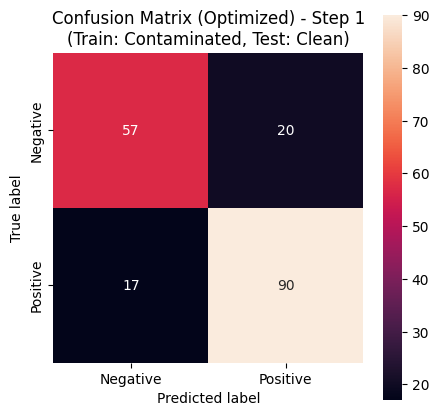


===== Training Optimized Decision Tree at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (OPT): 0.0012 sec
Step 2 | Training Accuracy (OPT): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


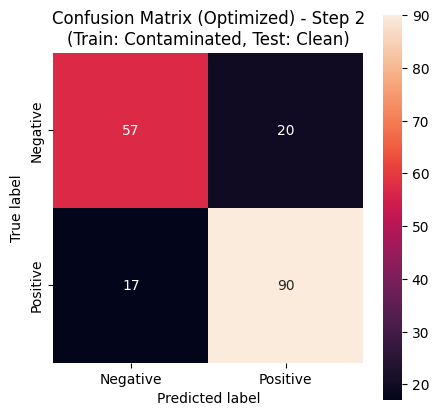


===== Training Optimized Decision Tree at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (OPT): 0.0016 sec
Step 3 | Training Accuracy (OPT): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


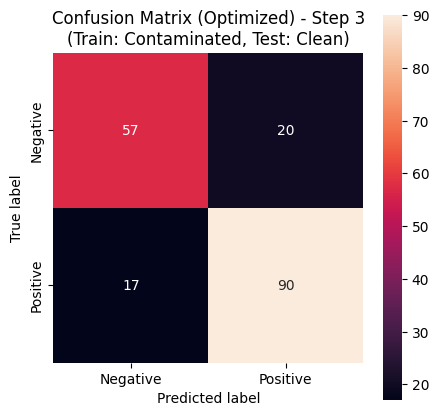


===== Training Optimized Decision Tree at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (OPT): 0.0016 sec
Step 4 | Training Accuracy (OPT): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


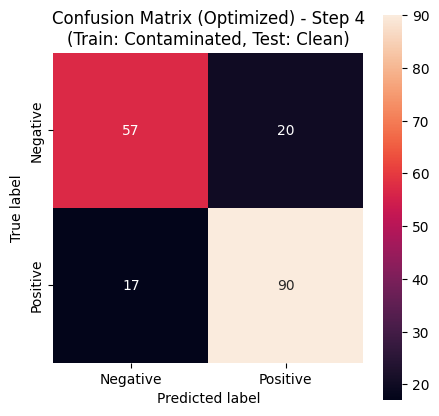


===== Training Optimized Decision Tree at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (OPT): 0.0014 sec
Step 5 | Training Accuracy (OPT): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


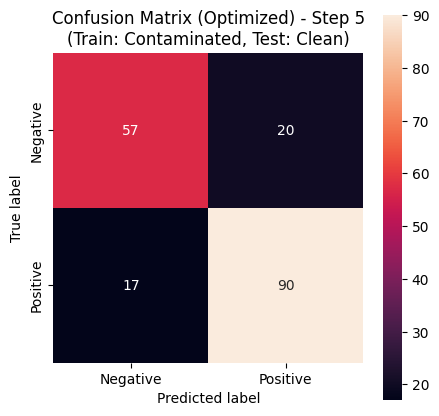


===== Training Optimized Decision Tree at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (OPT): 0.0018 sec
Step 6 | Training Accuracy (OPT): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


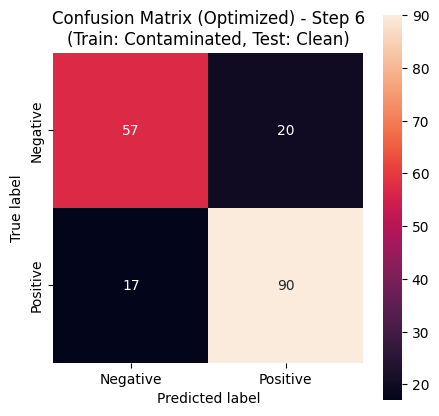


===== Training Optimized Decision Tree at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (OPT): 0.0013 sec
Step 7 | Training Accuracy (OPT): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


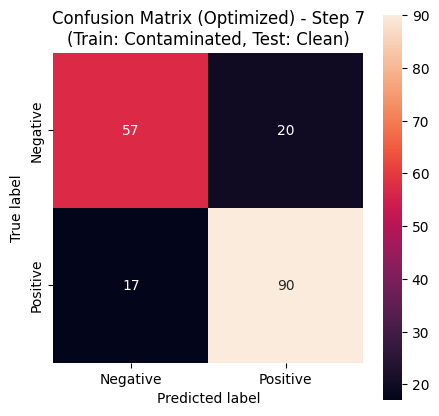


===== Training Optimized Decision Tree at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (OPT): 0.0012 sec
Step 8 | Training Accuracy (OPT): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


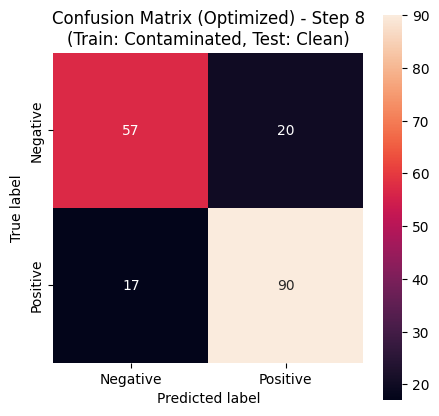


===== Training Optimized Decision Tree at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (OPT): 0.0012 sec
Step 9 | Training Accuracy (OPT): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


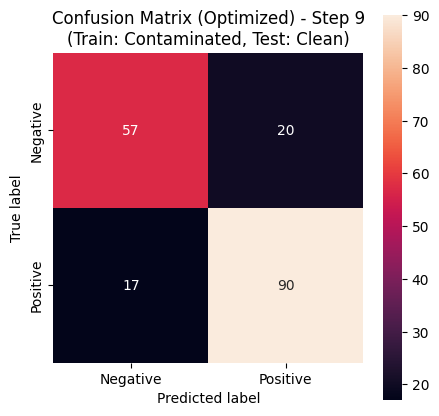


===== Training Optimized Decision Tree at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (OPT): 0.0011 sec
Step 10 | Training Accuracy (OPT): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


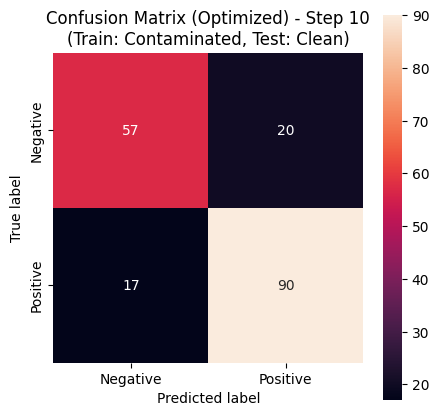

In [290]:
best_dt = joblib.load('best_decision_tree_model.pkl')

print("\n\n======================")
print("OPTIMIZED DECISION TREE")
print("======================\n")

for step_idx, contaminated_df in enumerate(datasets):
    print(f"\n===== Training Optimized Decision Tree at Step {step_idx} =====")
    
    # Prepara X e y dal dataset contaminato per il TRAINING
    X_contaminated = contaminated_df.drop('HeartDisease', axis=1)
    y_contaminated = contaminated_df['HeartDisease']
    
    # Split del dataset contaminato SOLO per il training
    X_train_contaminated, _, y_train_contaminated, _ = train_test_split(
        X_contaminated, y_contaminated, test_size=0.2, random_state=0
    )
    
    # Usa sempre test pulito
    X_train = X_train_contaminated
    y_train = y_train_contaminated
    X_test = X_test_clean
    y_test = y_test_clean
    
    print(f"Training set size: {len(X_train)} samples (contaminated)")
    print(f"Test set size: {len(X_test)} samples (clean)")
    
    if step_idx > 0:  # Solo per passi contaminati
        contaminated_training_samples = len(set(X_train.index) & generator.outlier_indices)
        print(f"Contaminated samples in training set: {contaminated_training_samples}")
    
    # Crea e addestra Decision Tree con i parametri migliori
    clf_opt = DecisionTreeClassifier(**best_dt, random_state=300)
    start_time = time.time()
    clf_opt.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Step {step_idx} | Training time (OPT): {training_time:.4f} sec")
    
    # Salva il tempo
    timing_collector_outliers[f'dt_optimized_training_step_{step_idx}'] = training_time
    
    # Accuracy sul training contaminato
    accuracy_train = clf_opt.score(X_train, y_train)
    print(f"Step {step_idx} | Training Accuracy (OPT): {accuracy_train:.4f}")
    
    # Predizioni sul test set pulito
    y_pred = clf_opt.predict(X_test)
    
    # Calcolo metriche
    dt_metrics_opt = calculate_metrics(y_test, y_pred, 'Decision Tree', 'Optimized', step_idx)
    dt_metrics_opt['training_time'] = training_time
    dt_metrics_opt['train_accuracy'] = accuracy_train
    dt_metrics_opt['contamination_step'] = step_idx
    dt_metrics_opt['test_set_type'] = 'clean'
    
    all_metrics_outliers.append(dt_metrics_opt)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f"Confusion Matrix (Optimized) - Step {step_idx}\n(Train: Contaminated, Test: Clean)")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

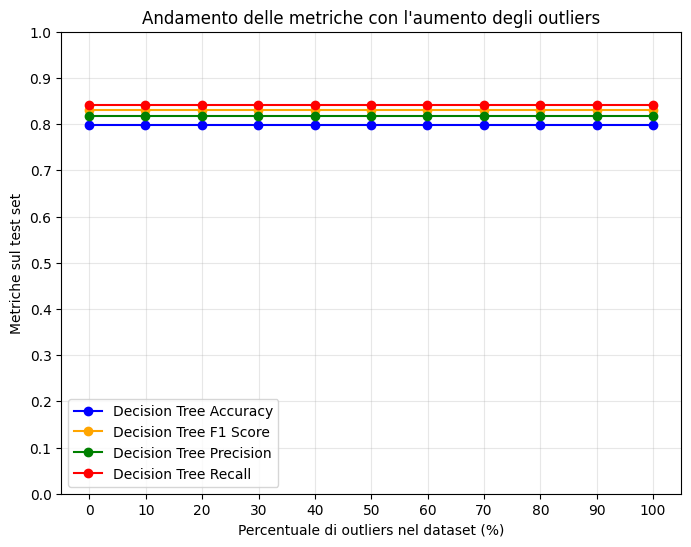

In [291]:
# Creo DataFrame da contamination_history con step e contamination rate
contam_df = pd.DataFrame([
    {"step": h['step'], "contamination_rate": h['actual_rate']}
    for h in contamination_history
])

# Aggiungo il caso iniziale (0% outliers)
if 0 not in contam_df["step"].values:
    contam_df = pd.concat([
        pd.DataFrame([{"step": 0, "contamination_rate": 0.0}]),
        contam_df
    ], ignore_index=True)

metrics_df = pd.DataFrame(all_metrics_outliers)

# Merge su 'step'
merged_df = pd.merge(metrics_df, contam_df, on="step", how="left")

# Ordino i valori
merged_df = merged_df.sort_values("contamination_rate")

# === FILTRO PER APPROACH ===
optimized_df = merged_df[(merged_df["approach"] == "Optimized") & (merged_df["model"] == "Decision Tree")]

# Plot accuracy vs contamination rate
plt.figure(figsize=(8,6))
plt.plot(optimized_df["contamination_rate"]*100, optimized_df["accuracy"], marker='o', color='blue', label="Decision Tree Accuracy")
plt.plot(optimized_df["contamination_rate"]*100, optimized_df["f1_score"], marker='o', color='orange', label="Decision Tree F1 Score")
plt.plot(optimized_df["contamination_rate"]*100, optimized_df["precision"], marker='o', color='green', label="Decision Tree Precision")
plt.plot(optimized_df["contamination_rate"]*100, optimized_df["recall"], marker='o', color='red', label="Decision Tree Recall")
plt.xlabel("Percentuale di outliers nel dataset (%)")
plt.ylabel("Metriche sul test set")
plt.title("Andamento delle metriche con l'aumento degli outliers")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 110, 10))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
